This notebook should give an example walkthrought of using the f4mine program, which is inspired by the f3ast package created by Luka Skoric and Amalion Fernandez-Pacheco's group

First, define the SEM settings:

In [1]:
from f4mine import sem
from matplotlib import pyplot as plt

sem_settings = sem.SEM(addressable_pixels=[65536, 56576],
                    screen_width=10.2e3,
                    )


Next, let's import a structure. In this example, we will actually import a stack of numpy arrays. This can also be done with an image stack.

In [2]:
from f4mine import structure

filepath = 'branchtrio-SizedUp.stl'

branched_trio = structure.import_mesh(filepath, pitch=100)

Slicing structure...
Slicing Completed!


We can visualize X-Y slices of our binary structure

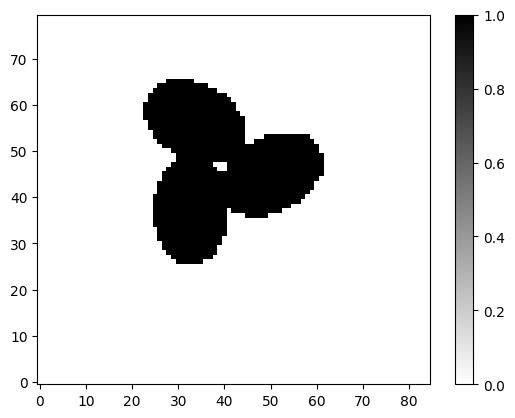

In [3]:
layer_slice = 37

branched_trio.plot_slice(layer_slice, type='structure')

Then, we can set the size and begin calculating some of the properties

In [4]:
size_x = 1000 #nm
size_y = 1000 #nm
size_z = 1000 #nm
branched_trio.set_size([size_x, size_y, size_z])

branched_trio.section()


Now we can access a wealth of properties

In [5]:
print(branched_trio.__dict__.keys())
 

dict_keys(['threshold', 'input_pitch', 'binary_array', 'structure_size_nm', 'labelled_regions', 'centers_pix', 'areas_pix', 'bounding_boxes_pix', 'euler_numbers', 'structure_size_fab', 'pix_size', 'pitch_nm', 'pitch_fab', 'areas', 'total_resistances', 'resistance_calculated_flag', 'dwell_list', 'layer_height', 'centers'])


Next, let's define our model and calculate the parameters for our fabrication. 

First, we will use the array model. It calculates resistances using series and parallel resistor approximations.

In [6]:
from f4mine import model 

GR0 = 250e-3 # in um/s, base growth rate
k = 1.5 # in 1/nm?, thermal conductivity
sigma = 4.4 # in nm, dwell size

mod = model.ArrayModel(branched_trio, gr=GR0, k=k, sigma=sigma, single_pixel_width=50, rho=1)

mod.calculate_resistance()
resarr1 = branched_trio.total_resistances

Layer resistances calculated
The path difference is 1
The path difference is 2
Total resistances calculated


#### We can resize the binary array and resistance array to get more fabrication points. By doing this after the previous steps, we can use an efficient spline interpolation to increase our fabrication density.

### Note that this overrides the object's property and this is not yet undoable!

In [7]:
branched_trio.resize([300,300,300])

Now let's calculate dwells with our resistance. There are two ways to do this. One method involves K-Tree nearest neighbor lookup, while another involves a fourier-space convolution between each layer and the inverse of a gaussian. The second method aims to correct for the gaussian blurring that will be caused by the beam.

In [8]:
from f4mine import dwell

sigma = 4.4 
pitch = 10
gr = 250
k = 1.5
sem_params = {"GR0": gr, "k":k}

solver = dwell.ConvolutionMethod(branched_trio, sigma, pitch=pitch, filter="inverse_gaussian", calibration_parameters=sem_params, kernel_size=5)
output = solver.convolution_solve()



# TO DO: Get dwells from solver.dwells and put into a stream file!